# Visualizing the distribution of episode trajectories

Note: video/image manipulation requires OpenCV, which isn't included in the conda environment setup for the rest of this project (out of fear of breaking other dependencies). To run this notebook, I suggest using a separate conda environment that has OpenCV installed (since we're just processing videos/images, the new conda environment doesn't need to have all the packages that `sport` has).

This can be done by following this guide: https://saturncloud.io/blog/installing-opencv-with-conda-a-guide-for-data-scientists/ (but use Python 3.10 instead).

Remember to also install the `ipykernel` and `matplotlib` packages for the new environment! `conda install ipykernel matplotlib`

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections.abc import Container
from matplotlib.figure import Figure
from matplotlib.axes import Axes

In [ ]:
def extract_frames(
    ep_idxs: Container[int],
    alphas: Container[float] | None = None,
    datetimes: Container[str] | None = None,
    prefix: str = "",
    backsub_mog: cv2.BackgroundSubtractor | None = None,
    backsub_knn: cv2.BackgroundSubtractor | None = None,
    learning_rate_mog: float = 0.01,
    learning_rate_knn: float = 0.01,
    history_mog: int = 500,
    history_knn: int = 500,
    mog2_var_threshold: int = 16,
    knn_dist2_threshold: int = 1000,
    crop_lims: tuple | None = None,
) -> tuple[dict, cv2.BackgroundSubtractor, cv2.BackgroundSubtractor]:
    """
    Extract frames from each episode video.
    """
    frames = {}
    if backsub_mog is None:
        backsub_mog = cv2.createBackgroundSubtractorMOG2(
            varThreshold=mog2_var_threshold, detectShadows=False, history=history_mog
        )
    if backsub_knn is None:
        backsub_knn = cv2.createBackgroundSubtractorKNN(
            dist2Threshold=knn_dist2_threshold, detectShadows=False, history=history_knn
        )
    if (alphas is None and datetimes is None) or (
        alphas is not None and datetimes is not None
    ):
        raise ValueError(
            "You must provide either a list of alphas or a list of datetimes."
        )
    if datetimes is not None:
        for datetime in datetimes:
            datetime_frames = []
            for ep_idx in ep_idxs:
                ep_frames = []
                cam = cv2.VideoCapture(
                    "../../src/sport/outputs/"
                    + prefix
                    + datetime
                    + "/videos/rl-video-episode-{ep_idx}.mp4".format(ep_idx=ep_idx)
                )
                while True:
                    ret, frame = cam.read()
                    if not ret:
                        break
                    if crop_lims is not None:
                        frame = frame[
                            crop_lims[0] : crop_lims[1], crop_lims[2] : crop_lims[3]
                        ]
                    fgmask = backsub_mog.apply(frame, learningRate=learning_rate_mog)
                    fgmask = backsub_knn.apply(frame, learningRate=learning_rate_knn)
                    ep_frames.append(frame)

                # For some reason, each video for ep_idx > 0 has 1 extra frame at the start from the end of the previous episode
                if ep_idx > 0:
                    ep_frames = ep_frames[1:]

                datetime_frames.append(ep_frames)
            frames[datetime] = datetime_frames

        cam.release()

    elif alphas is not None:
        for alpha in alphas:
            alpha_str = str(float(alpha)).replace(".", "-")
            alpha_frames = []
            for ep_idx in ep_idxs:
                ep_frames = []
                cam = cv2.VideoCapture(
                    "../../src/sport/videos/videos_alpha_"
                    + prefix
                    + alpha_str
                    + "/rl-video-episode-{ep_idx}.mp4".format(ep_idx=ep_idx)
                )
                while True:
                    ret, frame = cam.read()
                    if not ret:
                        break
                    if crop_lims is not None:
                        frame = frame[
                            crop_lims[0] : crop_lims[1], crop_lims[2] : crop_lims[3]
                        ]
                    fgmask = backsub_mog.apply(frame, learningRate=learning_rate_mog)
                    fgmask = backsub_knn.apply(frame, learningRate=learning_rate_knn)
                    ep_frames.append(frame)

                # For some reason, each video for ep_idx > 0 has 1 extra frame at the start from the end of the previous episode
                if ep_idx > 0:
                    ep_frames = ep_frames[1:]

                alpha_frames.append(ep_frames)
            frames[alpha] = alpha_frames

        cam.release()

    return frames, backsub_mog, backsub_knn


def plot_trajectories(
    frames: dict,
    keys: list,
    backsub_mog: cv2.BackgroundSubtractor,
    backsub_knn: cv2.BackgroundSubtractor,
    update_rate: float = 1.0,
    keypoint_size_cutoff: int = 40,
    blur_size: tuple[int, int] = (3, 3),
    blob_detector: cv2.SimpleBlobDetector | None = None,
    color: str = "b",
    fig_size_scale_factor_x: float = 1.0,
    fig_size_scale_factor_y: float = 1.0,
    line_width: float = 1.0,
    marker_size: float = 1.0,
    marker_alpha: float = 0.5,
    title: str | None = None,
    remove_collision_frame: bool = False,
    num_blurs: int = 0,
    inpainting_its: int = 0,
    inpainting_threshold: int = 5,
) -> tuple[Figure, Axes]:

    N = len(keys)
    fig, axs = plt.subplots(
        1,
        N,
        figsize=(fig_size_scale_factor_x * N, fig_size_scale_factor_y * 1),
        constrained_layout=True,
    )

    for k, key in enumerate(keys):
        trajectories = []
        positions = []
        for ep_frames in frames[key]:
            trajectory = backsub_mog.getBackgroundImage()
            ep_positions = []
            for idx in reversed(range(len(ep_frames))):
                gray = cv2.cvtColor(ep_frames[idx], cv2.COLOR_BGR2GRAY)
                gray_blurred = cv2.blur(gray, blur_size)
                keypoints = blob_detector.detect(gray_blurred)

                for kp in keypoints:
                    if kp.size <= keypoint_size_cutoff:
                        x, y = kp.pt
                        x, y = int(x), int(y)
                        ep_positions.append((x, y))

                fgmask = backsub_knn.apply(ep_frames[idx])
                fgmask = get_blurred_mask(fgmask, num_blurs=num_blurs)
                mean_kernel = np.ones((3, 3), np.float32) / 9
                for _ in range(inpainting_its):
                    average = cv2.filter2D(fgmask, -1, mean_kernel)
                    average_mask = (average >= inpainting_threshold / 9 * 255).astype(
                        "uint8"
                    ) * 255
                    fgmask = cv2.add(fgmask, average_mask)

                # Set all elements of fgmask to 0 except those within a square centered on (x, y)
                square_size = keypoint_size_cutoff + 10
                half_size = square_size // 2
                fgmask[: max(0, y - half_size), :] = 0
                fgmask[min(fgmask.shape[0], y + half_size) :, :] = 0
                fgmask[:, : max(0, x - half_size)] = 0
                fgmask[:, min(fgmask.shape[1], x + half_size) :] = 0

                if (
                    remove_collision_frame
                    and (idx == len(ep_frames) - 1)
                    and 50 < x < 100
                    and 70 < y < 170
                ):
                    # remove_collision_frame stops the frame being added if the agent collides with the hazard
                    # this removes the big red 'collision' sphere that appears when the agent enters the hazard
                    # note that we still keep the ep_position for this frame to show it enters the hazard
                    pass
                else:
                    trajectory[fgmask > 0] = (
                        trajectory[fgmask > 0] * (1 - update_rate)
                        + ep_frames[idx][fgmask > 0] * update_rate
                    )

            trajectories.append(trajectory)
            positions.append(ep_positions)

        trajectory_distribution = np.mean(trajectories, axis=0)

        axs[k].imshow(
            cv2.cvtColor(trajectory_distribution.astype("uint8"), cv2.COLOR_BGR2RGB)
        )

        for ep_positions in positions:
            # Extract x and y coordinates from ep_positions
            x_coords = [pos[0] for pos in ep_positions]
            y_coords = [pos[1] for pos in ep_positions]

            axs[k].plot(
                x_coords,
                y_coords,
                linestyle="-",
                linewidth=line_width,
                marker="o",
                markersize=marker_size,
                color=color,
                alpha=marker_alpha,
            )
        axs[k].set_title(r"$\alpha = {alpha}$".format(alpha=key))
        axs[k].axis("off")
    if title is not None:
        fig.suptitle(title)
    return fig, axs


def get_blurred_mask(
    fg_mask, min_thresh=0, kernel=np.array((9, 9), dtype=np.uint8), num_blurs=1
):
    """Obtains blurred image mask
    Inputs:
        fg_mask - foreground mask
        kernel - kernel for Morphological Operations
    Outputs:
        mask - Thresholded mask for moving pixels
    """
    blurred_mask = fg_mask
    for _ in range(num_blurs):
        _, thresh = cv2.threshold(blurred_mask, min_thresh, 255, cv2.THRESH_BINARY)
        blurred_mask = cv2.medianBlur(thresh, 3)

        # morphological operations
        blurred_mask = cv2.morphologyEx(
            blurred_mask, cv2.MORPH_OPEN, kernel, iterations=1
        )
        blurred_mask = cv2.morphologyEx(
            blurred_mask, cv2.MORPH_CLOSE, kernel, iterations=1
        )

    return blurred_mask

In [3]:
# Alphas
alphas = [1.0, 1.05, 1.1, 1.2, 1.35, 1.5, 2.0, 3.0, 5.0, 10.0, 20, 50.0, 100.0]

# Episode indices
ep_idxs = np.arange(0, 1000, 100)

# Video cropping
crop_lims = (0, 200, 0, 200)

# Background subtraction params
backsub_mog = None
backsub_knn = None
learning_rate_mog = 0.005
learning_rate_knn = 0.01
mog2_var_threshold = 16
knn_dist2_threshold = 2000
history_mog = 100
history_knn = 100

In [4]:
# Extract frames
frames, backsub_mog, backsub_knn = extract_frames(
    ep_idxs=ep_idxs,
    alphas=alphas,
    backsub_mog=backsub_mog,
    backsub_knn=backsub_knn,
    learning_rate_mog=learning_rate_mog,
    learning_rate_knn=learning_rate_knn,
    history_mog=history_mog,
    history_knn=history_knn,
    crop_lims=crop_lims,
    mog2_var_threshold=mog2_var_threshold,
    knn_dist2_threshold=knn_dist2_threshold,
)

frames_alpha_task, backsub_mog, backsub_knn = extract_frames(
    ep_idxs=ep_idxs,
    alphas=alphas,
    prefix="task_",
    backsub_mog=backsub_mog,
    backsub_knn=backsub_knn,
    learning_rate_mog=learning_rate_mog,
    learning_rate_knn=learning_rate_knn,
    history_mog=history_mog,
    history_knn=history_knn,
    crop_lims=crop_lims,
    mog2_var_threshold=mog2_var_threshold,
    knn_dist2_threshold=knn_dist2_threshold,
)

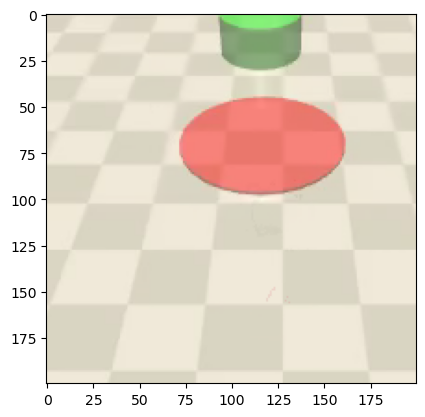

In [5]:
# Check background subtraction is working
plt.imshow(
    cv2.cvtColor(backsub_mog.getBackgroundImage().astype("uint8"), cv2.COLOR_BGR2RGB)
)
plt.show()

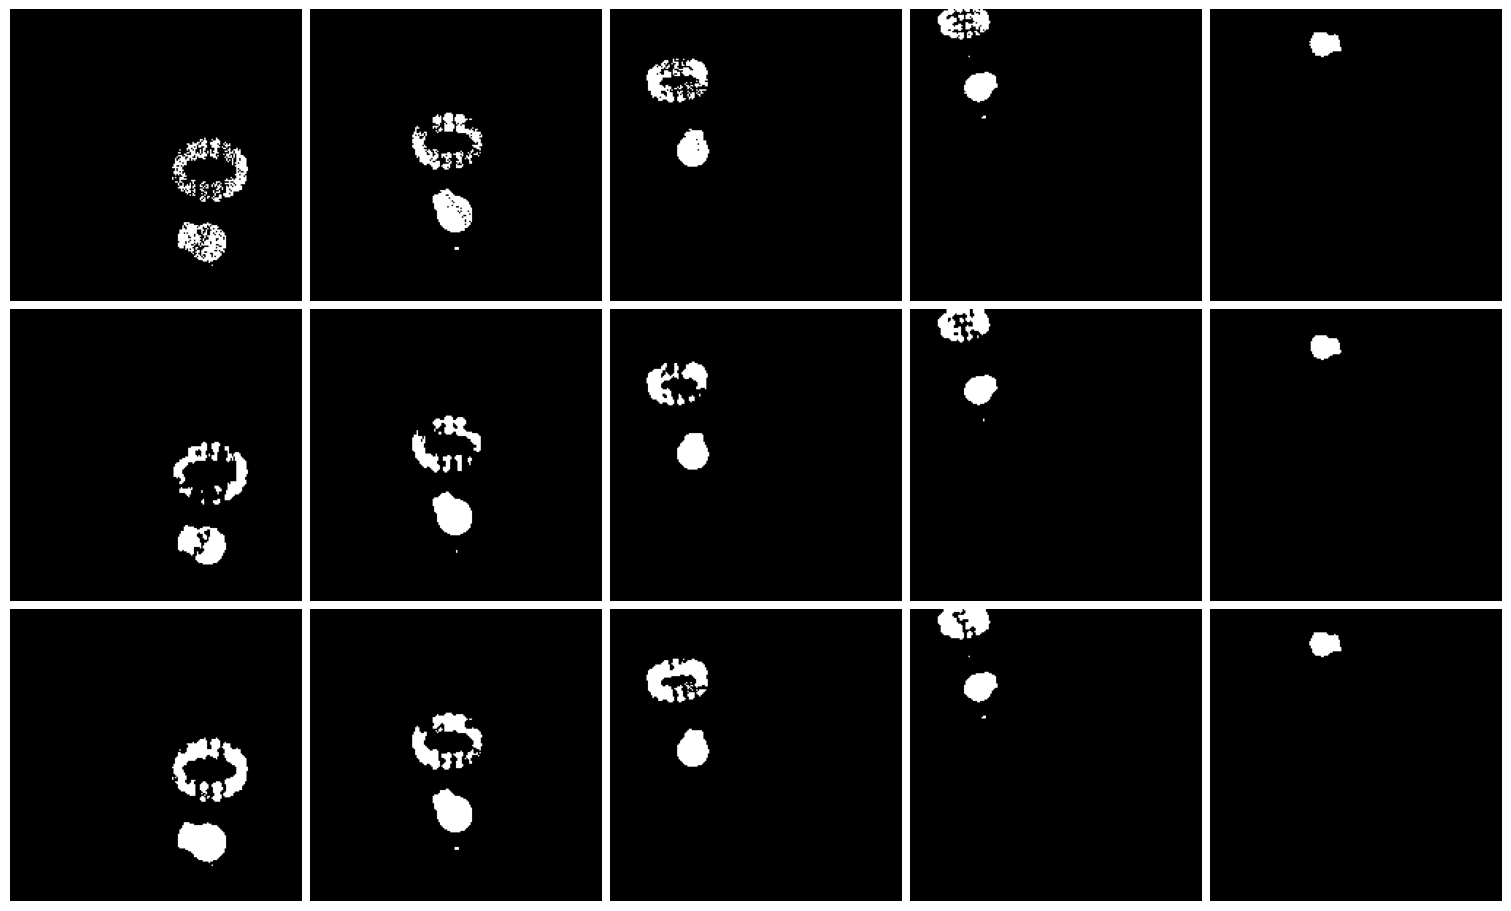

In [6]:
fgmask = backsub_knn.apply(frames[1][0][3])
N = 5
fig, axs = plt.subplots(
    3,
    N,
    figsize=(3 * N, 3 * 3),
    constrained_layout=True,
)
axs = axs.ravel()
for k in range(N):
    fgmask = backsub_knn.apply(frames[1][0][k * 3])
    blurred_mask = get_blurred_mask(fgmask)
    inpainting_its = 6
    inpainting_threshold = 5
    inpainted_mask = np.copy(fgmask)
    mean_kernel = np.ones((3, 3), np.float32) / 9
    for it in range(inpainting_its):
        average = cv2.filter2D(inpainted_mask, -1, mean_kernel)
        average_mask = (average >= inpainting_threshold / 9 * 255).astype("uint8") * 255
        inpainted_mask = cv2.add(inpainted_mask, average_mask)
    axs[k].imshow(cv2.cvtColor(fgmask, cv2.COLOR_GRAY2BGR))
    axs[k].axis("off")
    axs[k + N].imshow(cv2.cvtColor(blurred_mask, cv2.COLOR_GRAY2BGR))
    axs[k + N].axis("off")
    axs[k + 2 * N].imshow(cv2.cvtColor(inpainted_mask, cv2.COLOR_GRAY2BGR))
    axs[k + 2 * N].axis("off")
plt.show()

In [7]:
# Blob detection params
params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.minArea = 100
params.filterByCircularity = True
params.filterByConvexity = False
params.filterByInertia = False

# Create blob detector
blob_detector = cv2.SimpleBlobDetector_create(params)

# Plotting params
update_rate = 1.0
keypoint_size_cutoff = 40
blur_size = (3, 3)

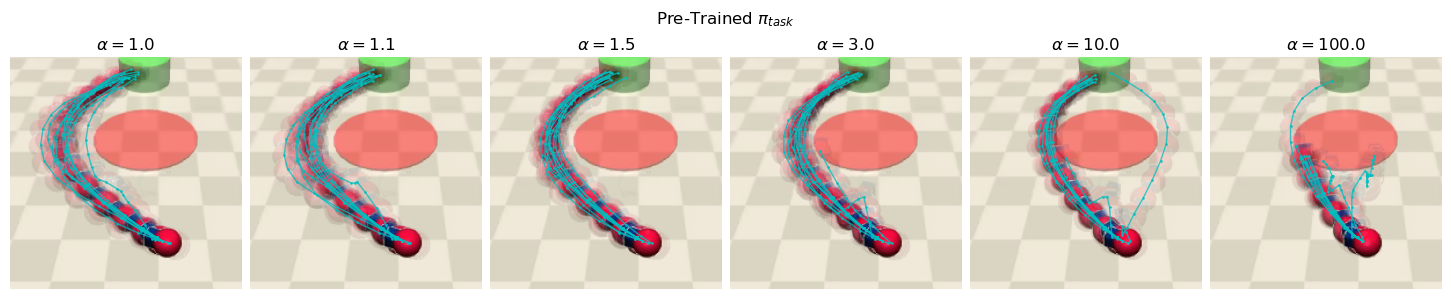

In [35]:
alphas_to_plot = [1.0, 1.1, 1.5, 3.0, 10.0, 100.0]
# alphas_to_plot = alphas

fig, ax = plot_trajectories(
    frames=frames,
    keys=alphas_to_plot,
    backsub_mog=backsub_mog,
    backsub_knn=backsub_knn,
    update_rate=update_rate,
    keypoint_size_cutoff=keypoint_size_cutoff,
    blur_size=blur_size,
    blob_detector=blob_detector,
    color="c",
    fig_size_scale_factor_x=2.4,
    fig_size_scale_factor_y=3.0,
    line_width=1.0,
    marker_size=1.0,
    marker_alpha=0.75,
    title=r"Pre-Trained $\pi_{task}$",
    remove_collision_frame=True,
    num_blurs=0,
    inpainting_its=25,
    inpainting_threshold=5,
)
plt.savefig("pretrained_trajectories.svg")

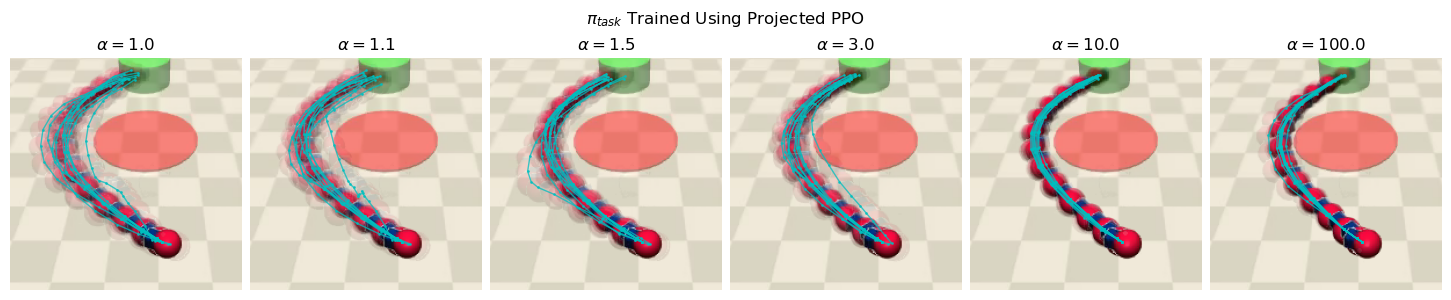

In [13]:
alphas_to_plot = [1.0, 1.1, 1.5, 3.0, 10.0, 100.0]
# alphas_to_plot = alphas

fig, ax = plot_trajectories(
    frames=frames_alpha_task,
    keys=alphas_to_plot,
    backsub_mog=backsub_mog,
    backsub_knn=backsub_knn,
    update_rate=update_rate,
    keypoint_size_cutoff=keypoint_size_cutoff,
    blur_size=blur_size,
    blob_detector=blob_detector,
    color="c",
    fig_size_scale_factor_x=2.4,
    fig_size_scale_factor_y=3.0,
    line_width=1.0,
    marker_size=1.0,
    marker_alpha=0.75,
    title=r"$\pi_{task}$ Trained Using Projected PPO",
    remove_collision_frame=True,
    num_blurs=0,
    inpainting_its=25,
    inpainting_threshold=5,
)
plt.savefig("constrained_trajectories.svg")